# Notebook 04 - Feature Engineering

## Objectives

Engineer Features for:
* Classification
* Regression
* Clustering

## Inputs
* outputs/datasets/cleaned/test.csv

## Outputs
* Create Clean dataset:
    * all new datasets of cleaning will be stored in inputs/datasets/cleaning
* Split created dataset in to 3 parts:
    * Train
    * Validate
    * Test
* all new datasets (train, validate and test) will be stored in outputs/datasets/cleaned

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df_train = pd.read_parquet('outputs/datasets/cleaned/train.parquet.gzip')
df_train.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice,Consistency
809,809,1075,1063,2,No,0,Unf,849,0,360,...,0,156,5,5,849,0,1898,1965,106000,True
608,608,1940,1254,4,Mn,428,BLQ,537,0,380,...,0,0,6,8,965,0,1934,1998,359100,True
1189,1189,1028,776,3,No,0,Unf,994,0,442,...,0,60,5,7,994,0,1999,1999,189000,True
1039,1039,630,0,1,Av,509,GLQ,121,0,286,...,0,0,4,4,630,0,1970,1970,80000,True
1297,1297,1072,0,2,Gd,547,GLQ,0,0,525,...,82,44,5,6,547,0,2005,2006,140000,True


## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we will select these features:

In [5]:
# importing home-made functions
from extra_funcionality import load_data

# getting list of selected features
hypothesis_1_features = load_data('hypothesis_1_features')
hypothesis_1_features

['BsmtFinType1',
 'KitchenQual',
 'OverallQual',
 'BsmtExposure',
 'GrLivArea',
 'GarageFinish',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'YearBuilt',
 'SalePrice']

In [6]:
# In dataframe keeping just selected features
df_train = df_train[hypothesis_1_features]

## Features Engineering

### Functions for transforming

We have added extra feature - results
It will be printed out on each analysis, also at the end of FeatureEngineeringAnalysis it will be returned to us, so we can analyze it bit easier.

In [7]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
import warnings

warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape 
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
  
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respectives column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    ### Check analysis type
    if analysis_type == None:
        raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    ### Set suffix columns according to analysis_type
    if analysis_type == 'numerical':
        list_column_transformers = ["log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=['#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    ### Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    ### LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

        ### LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    ### ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    ### PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    ### BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    ### YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Categorical Encoding

Before We proceed with Deeper analysis, first we have to do:
1. Get list of features that are categorical
2. Get list of features that are numerical

In [8]:
# Getting list of categorical features

categorical_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['BsmtFinType1', 'KitchenQual', 'BsmtExposure', 'GarageFinish']

In [9]:
# Getting list of numerical features
numerical_features = df_train.select_dtypes(include=['int', 'float']).columns.tolist()
numerical_features

['OverallQual',
 'GrLivArea',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'YearBuilt',
 'SalePrice']

#### Encoding Categorical Features and exploring distribution

* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



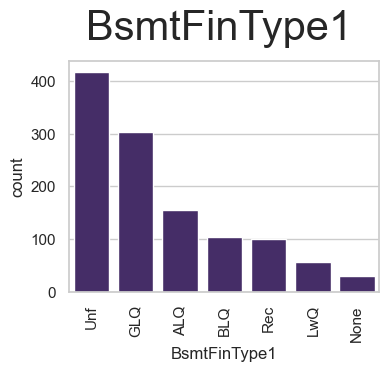

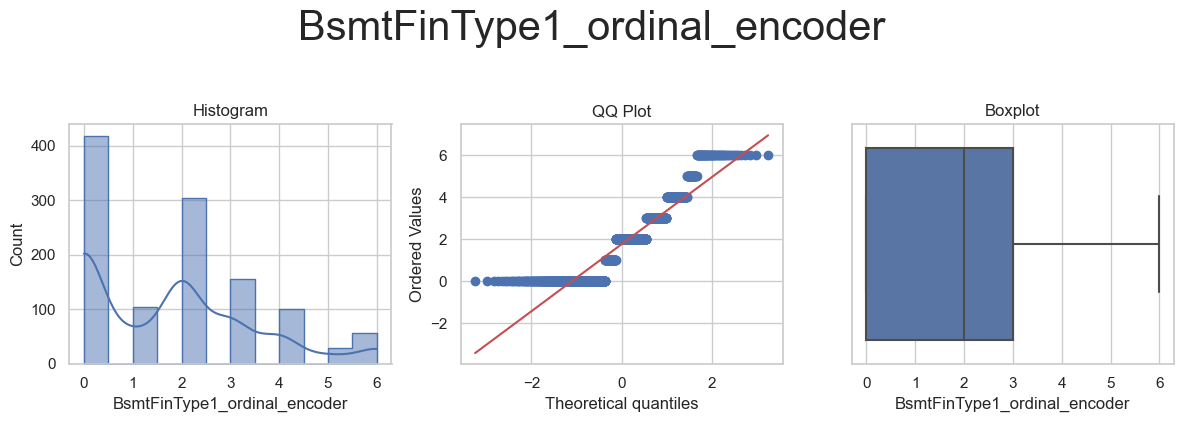



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



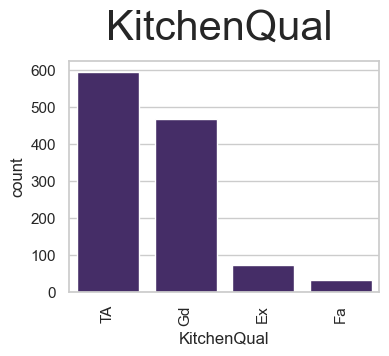

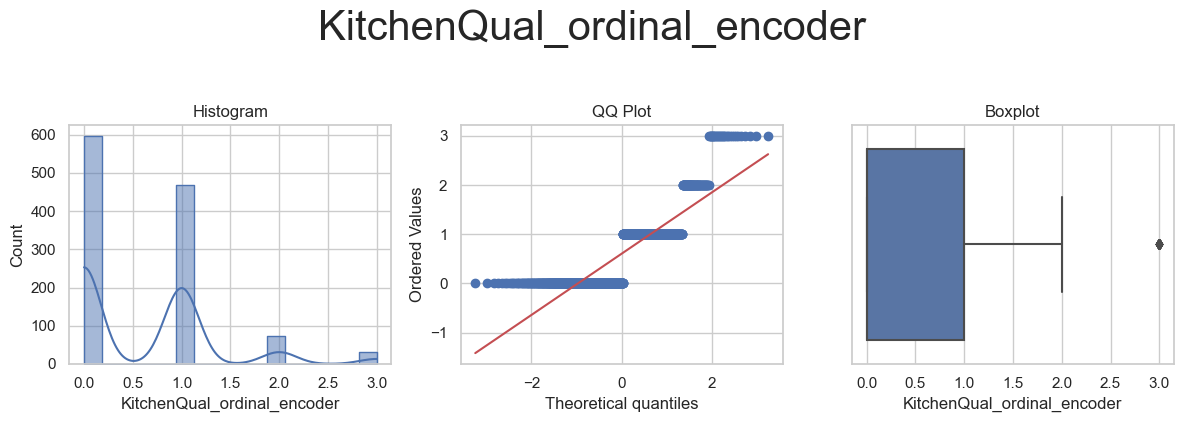



* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



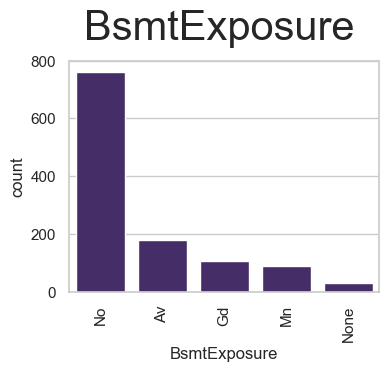

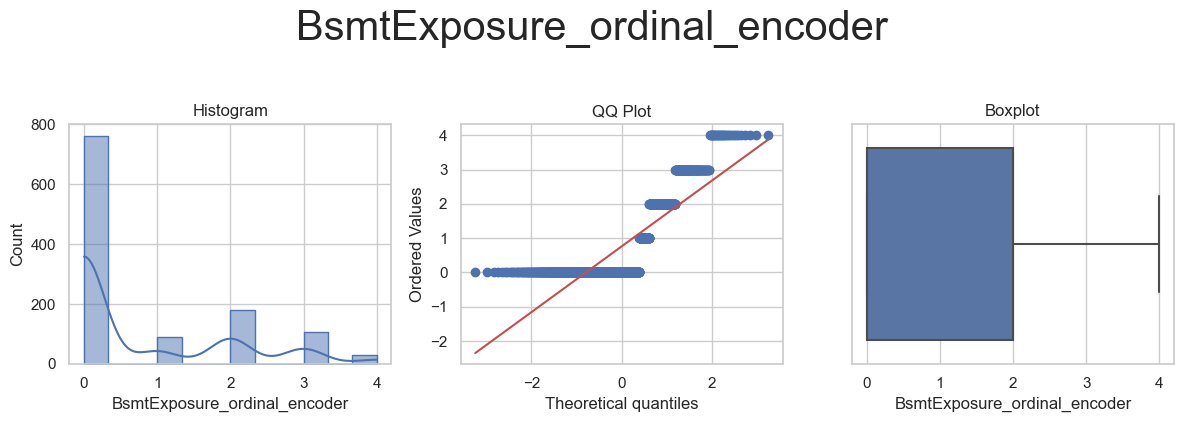



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



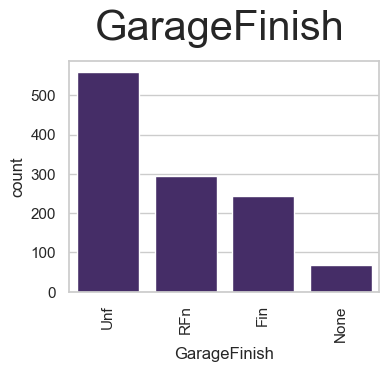

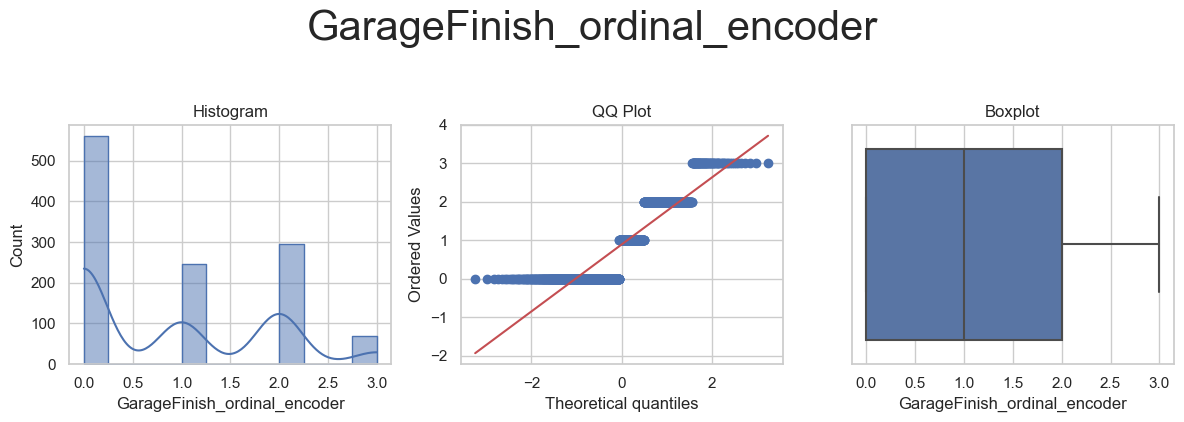

In [10]:
df_train_categorical = FeatureEngineeringAnalysis(df=df_train[categorical_features], analysis_type='ordinal_encoder')

We can not notice anything extraordinary, all looks pretty normal.

#### Inspecting dataframe for columns that might not need to be transformed

We also want to analyse SalePrice. Maybe it needs transformations.

* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



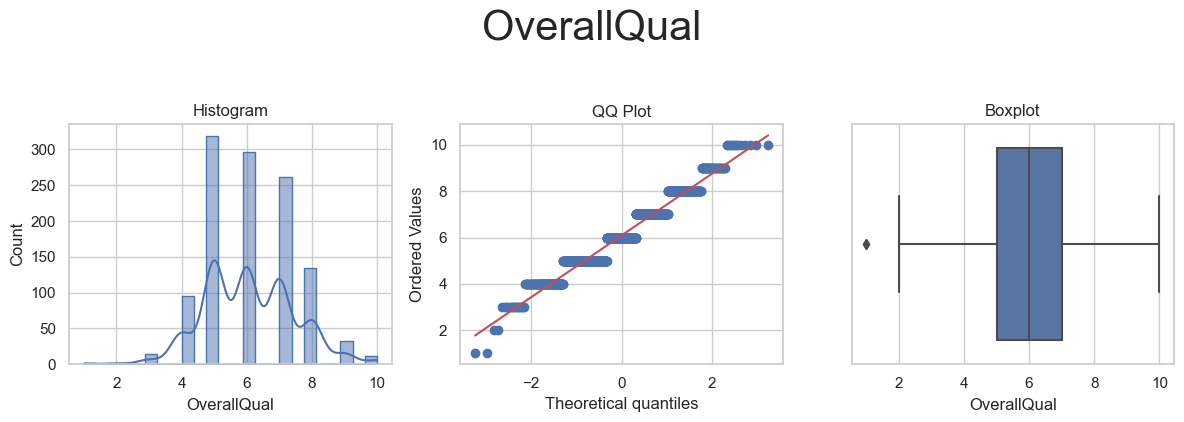

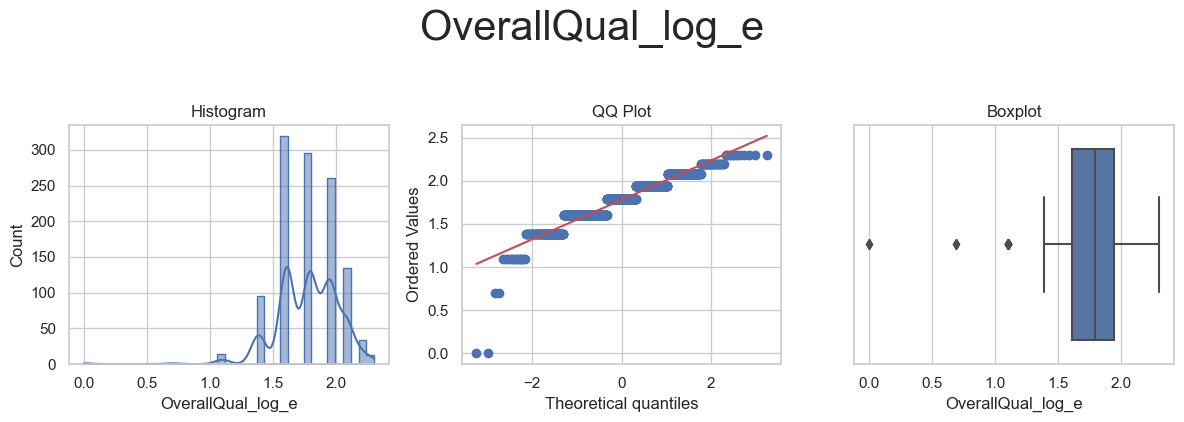

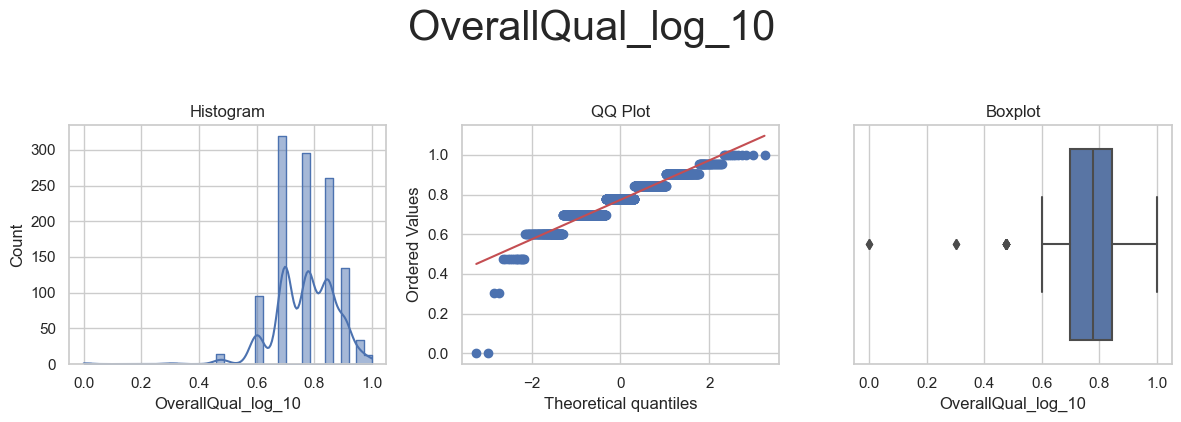

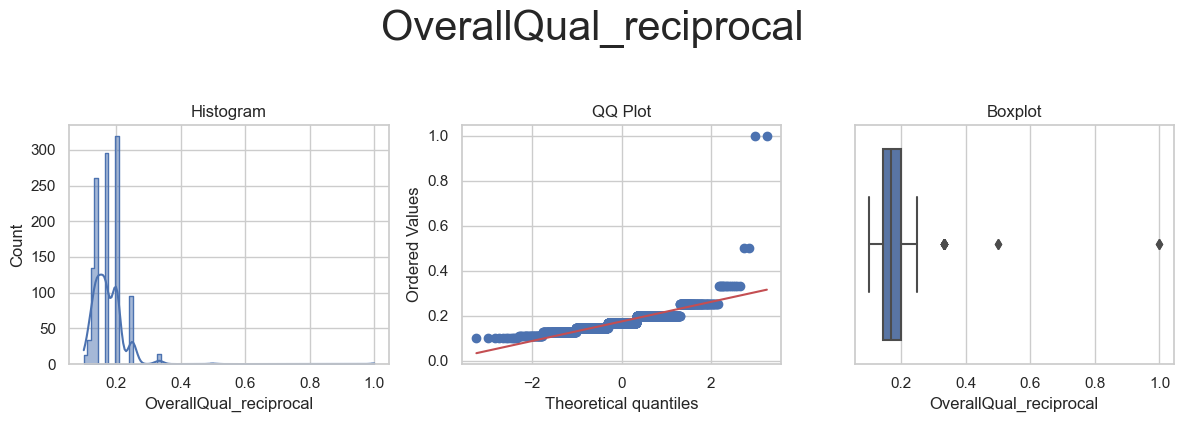

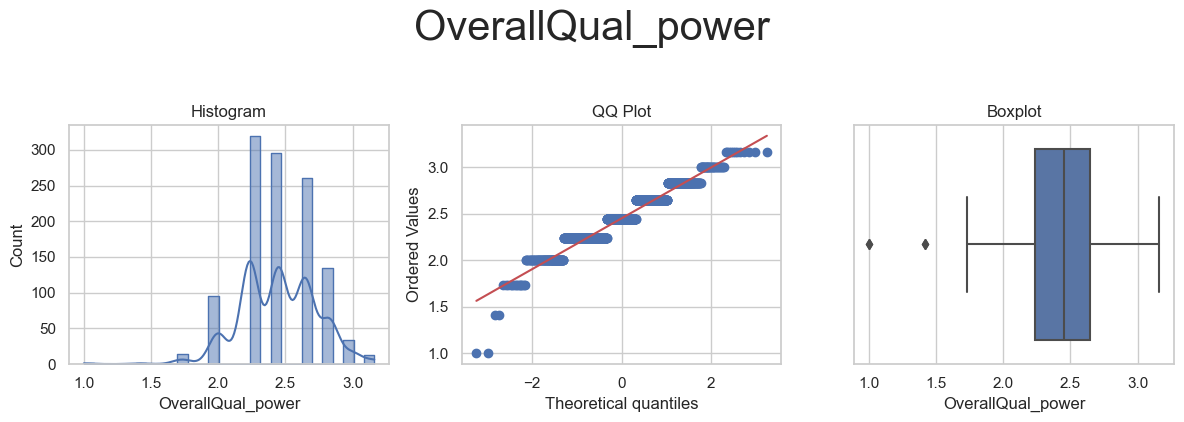

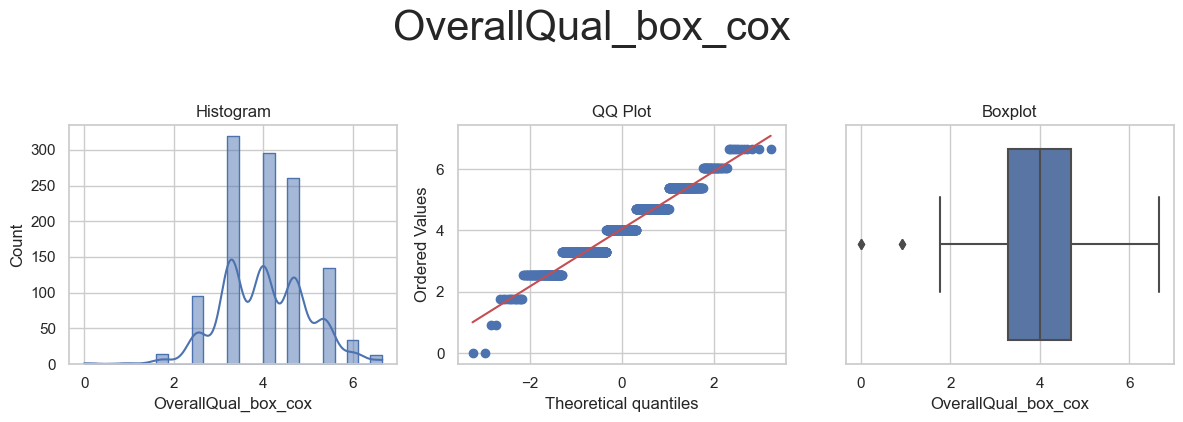

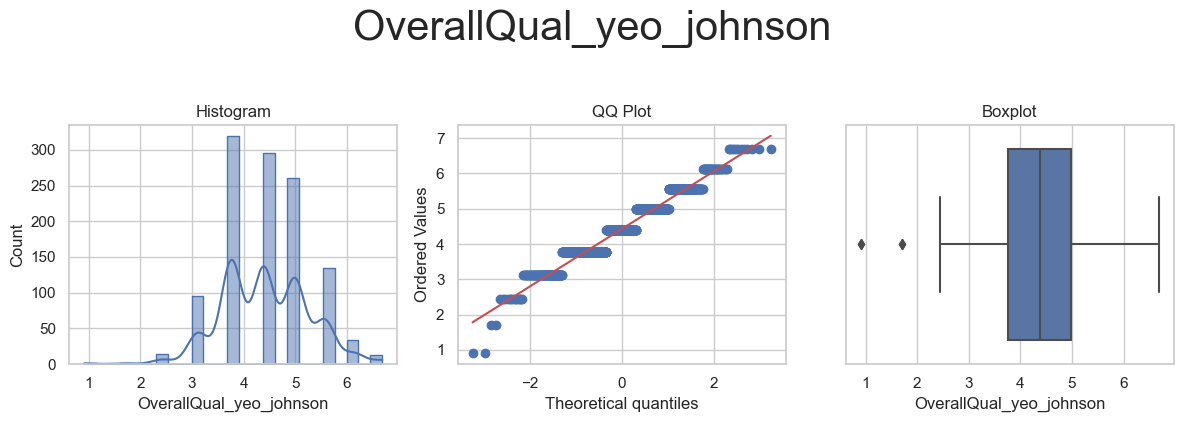



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



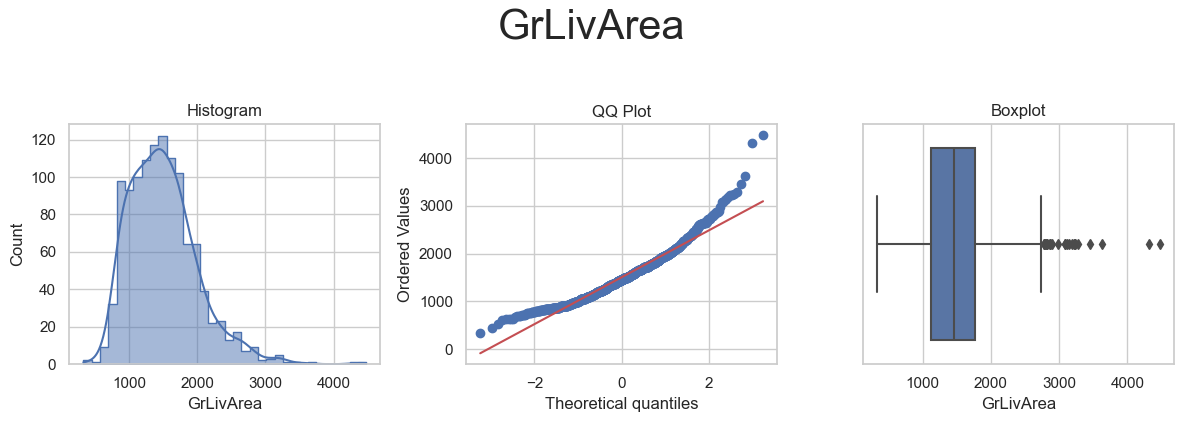

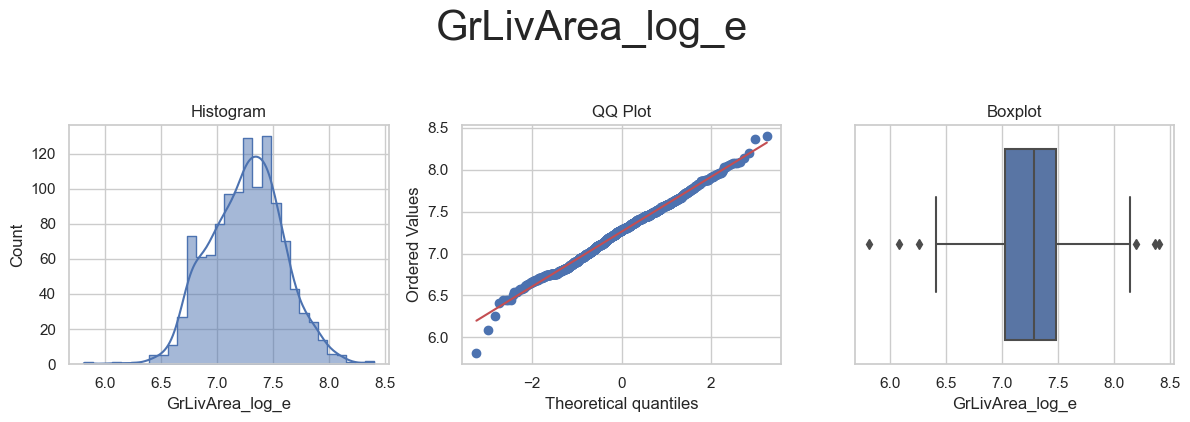

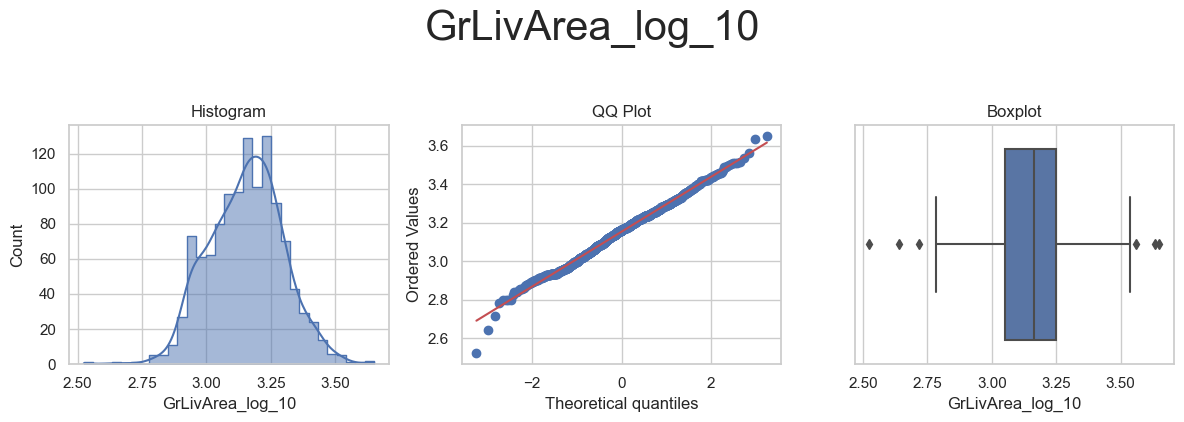

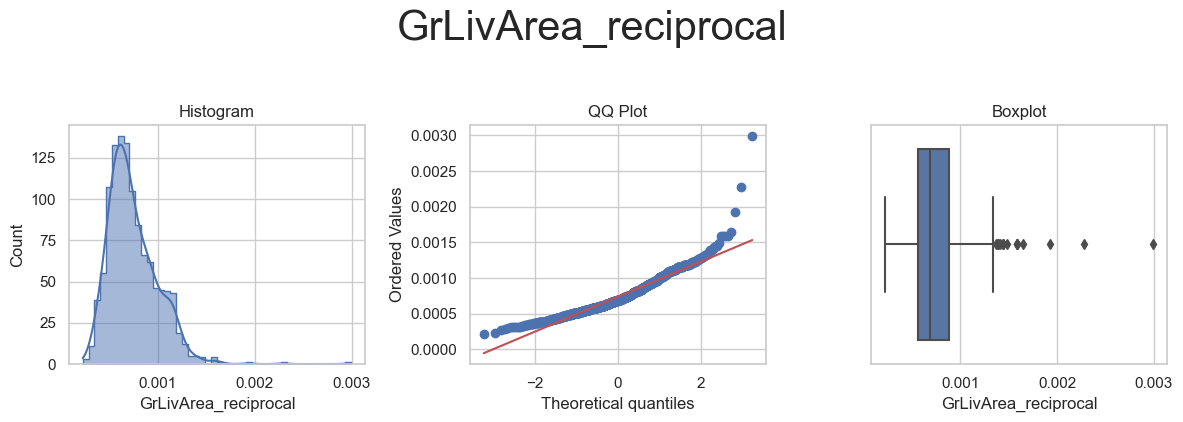

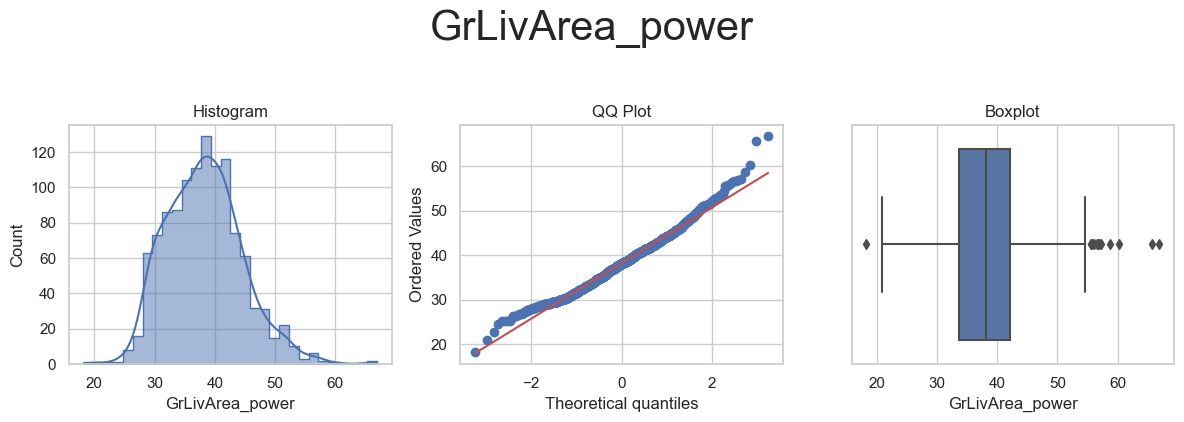

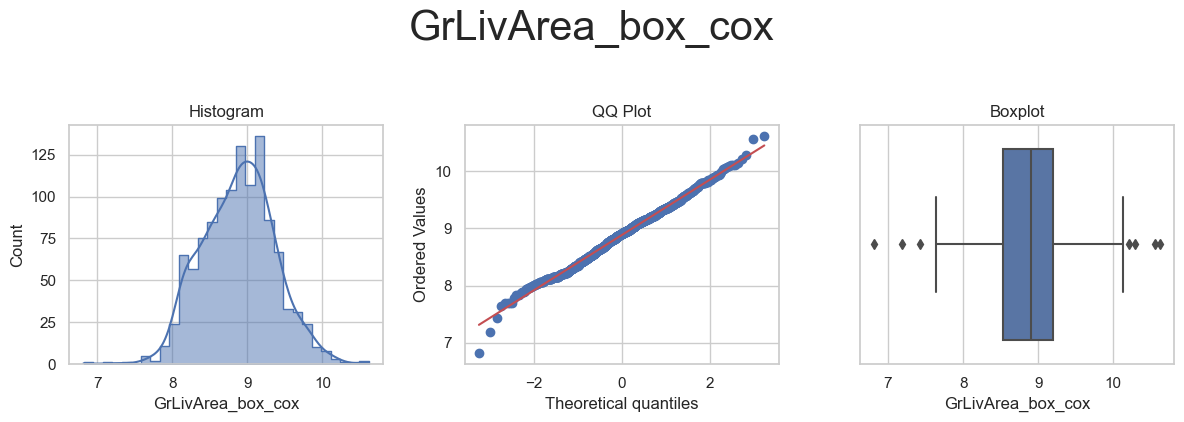

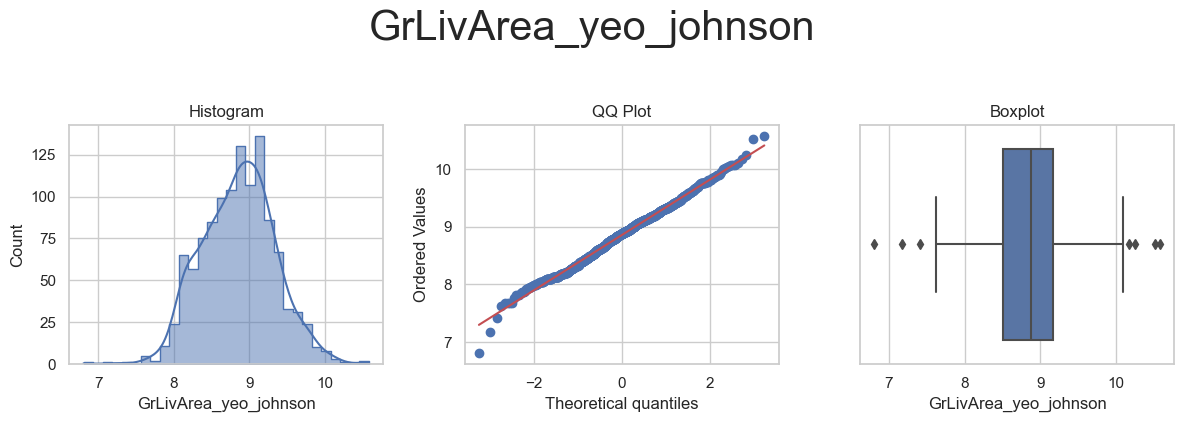



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



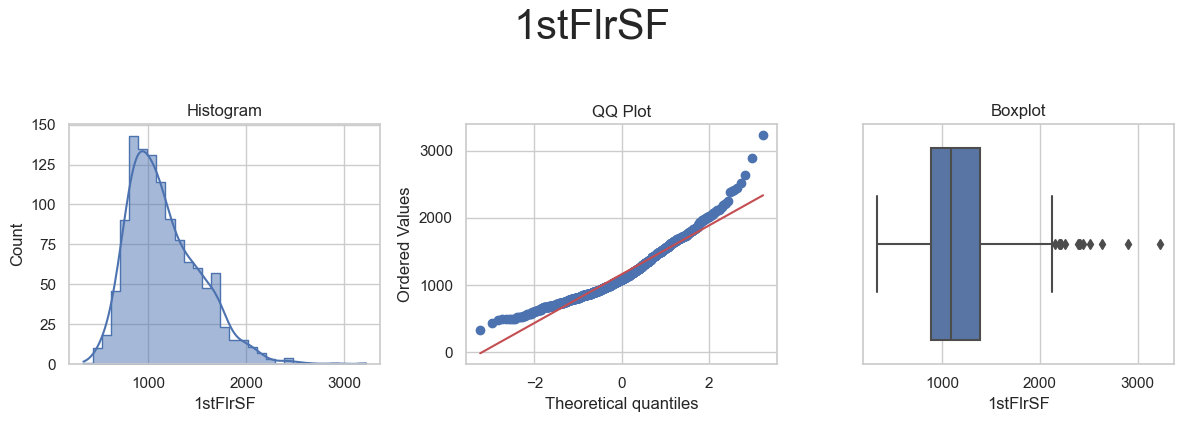

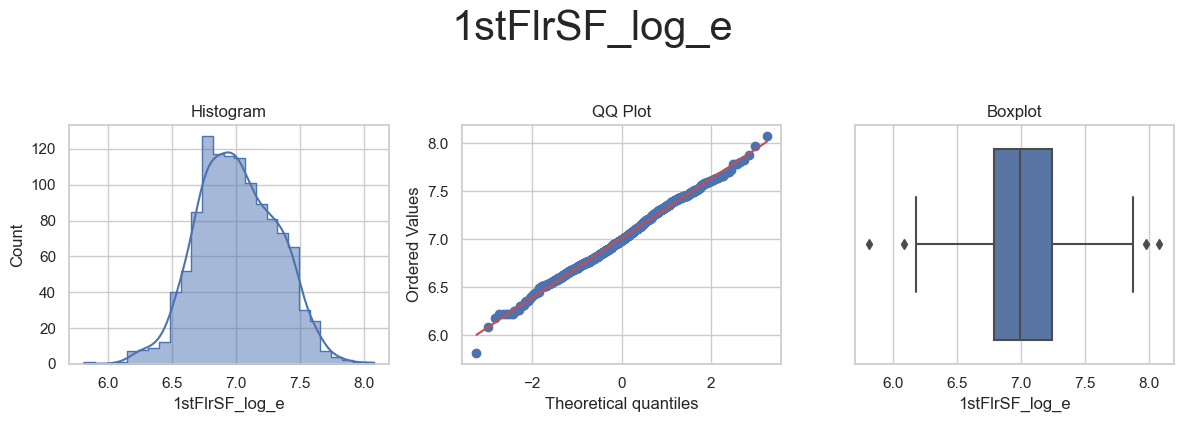

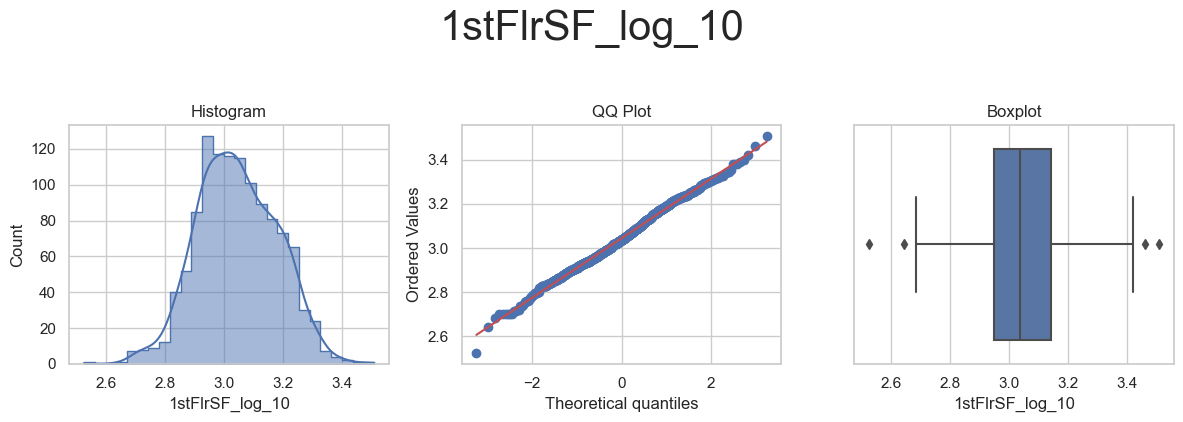

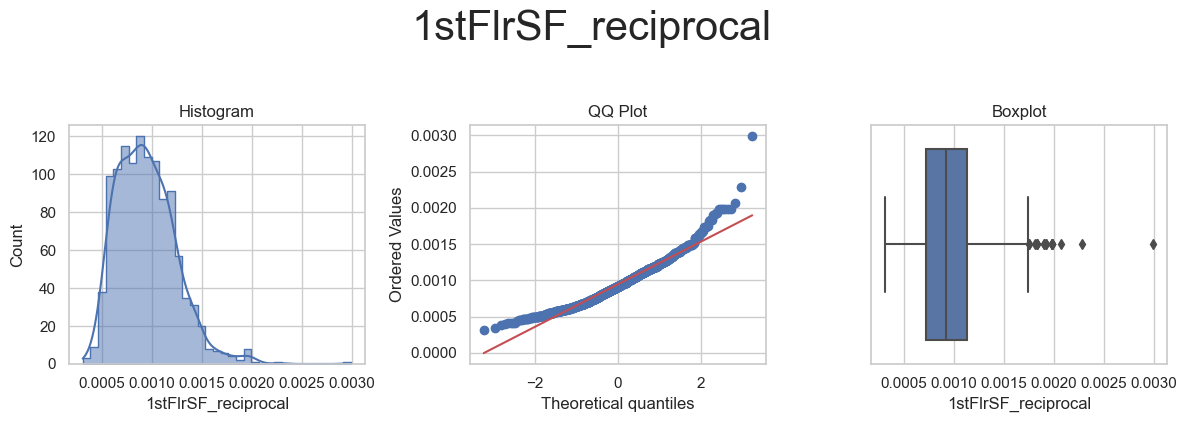

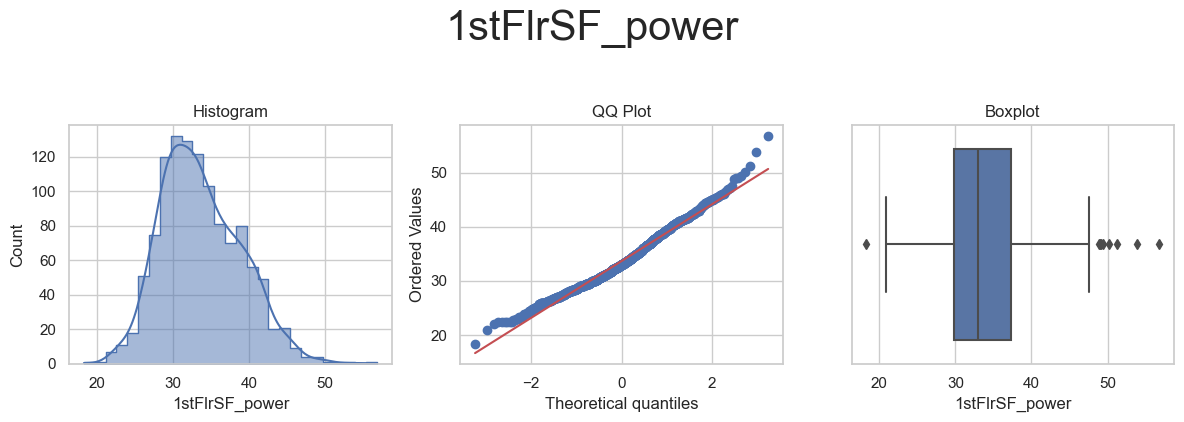

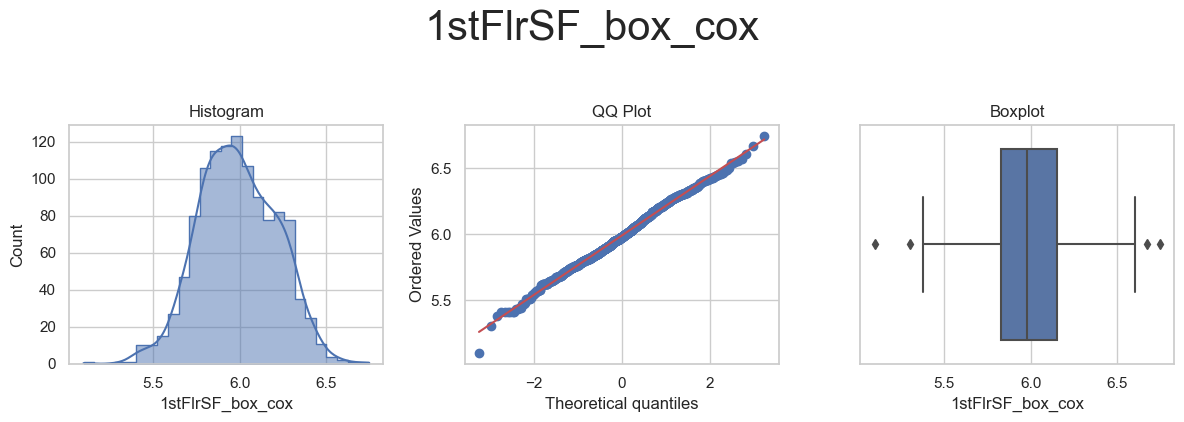

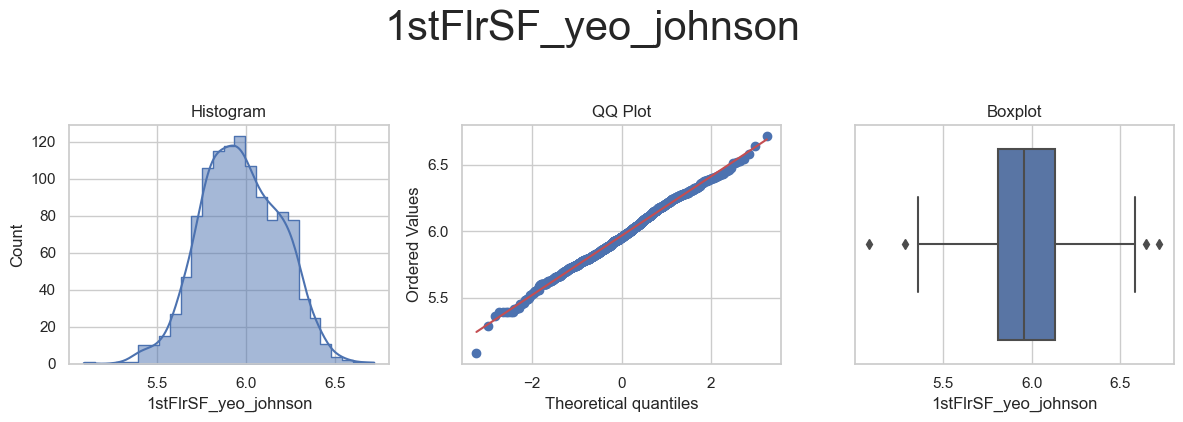



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



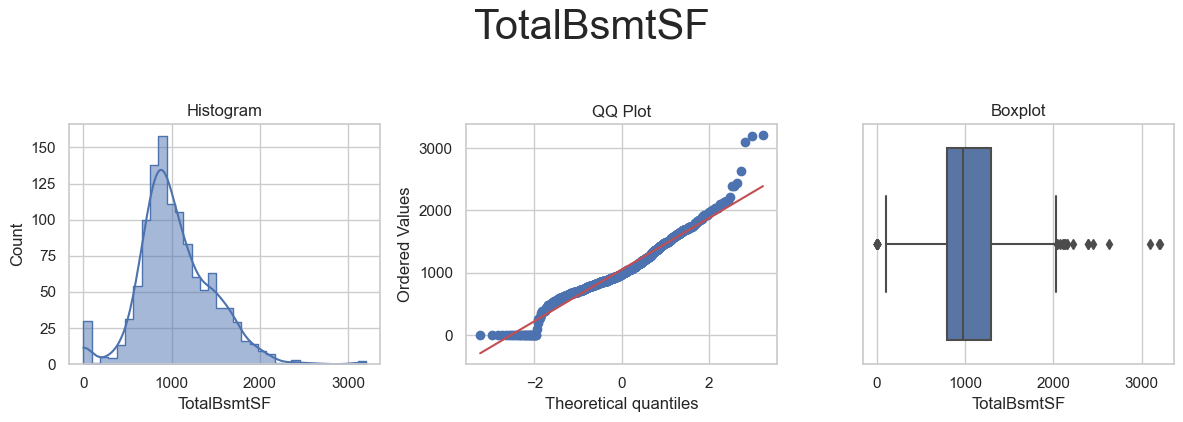

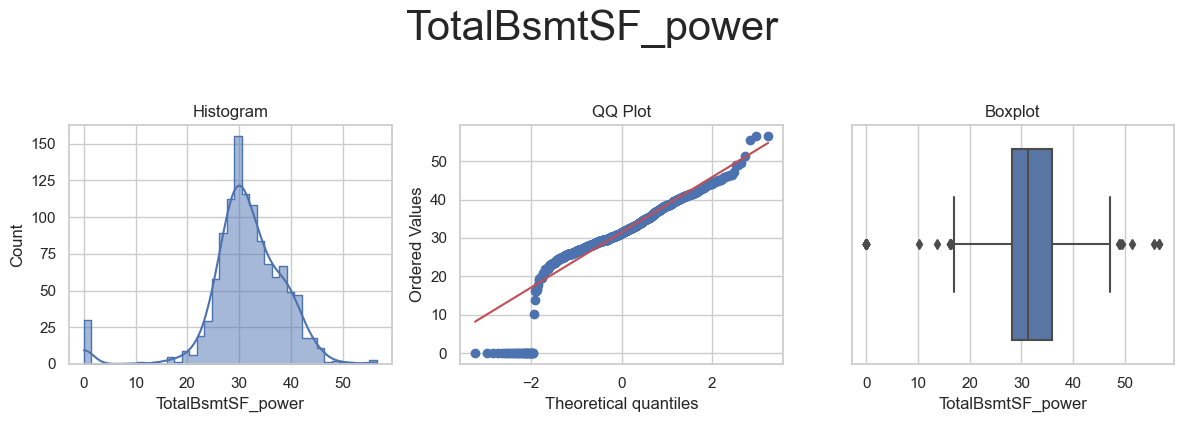

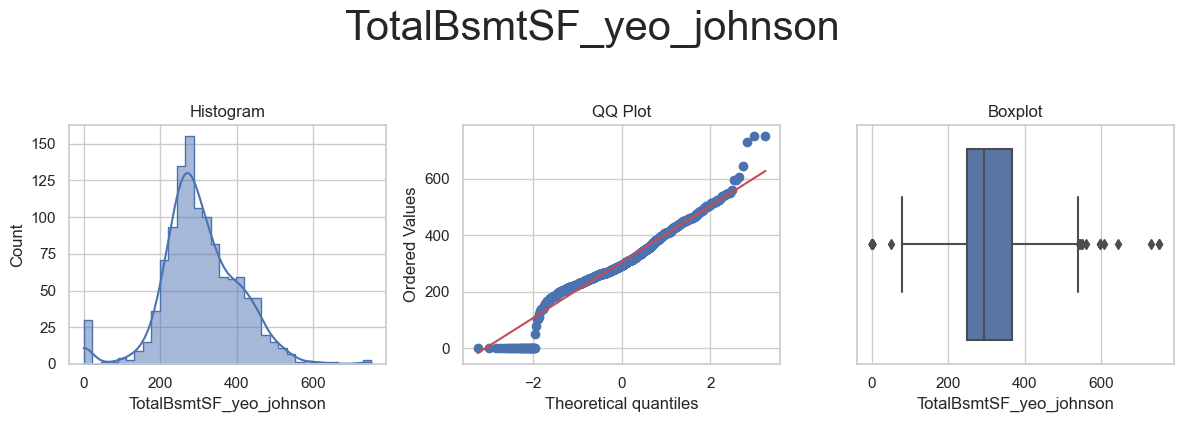



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



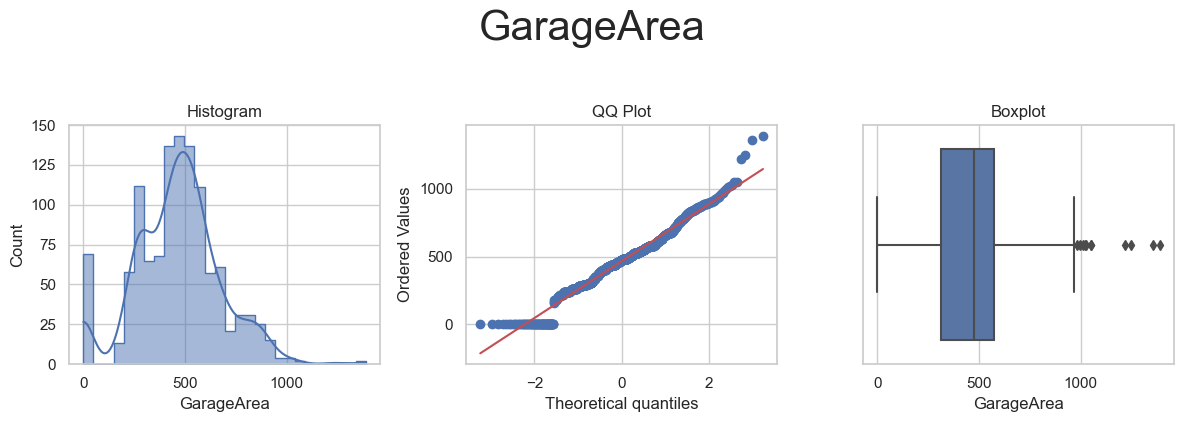

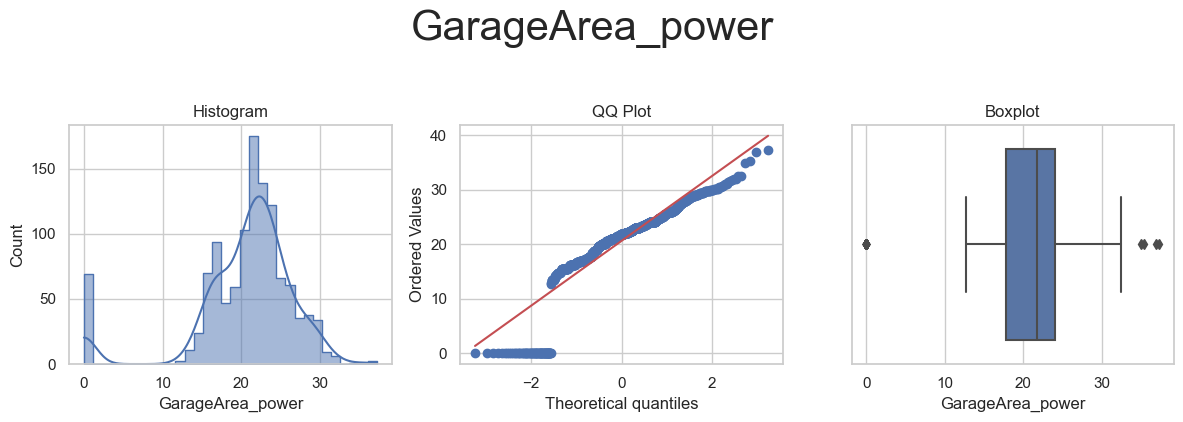

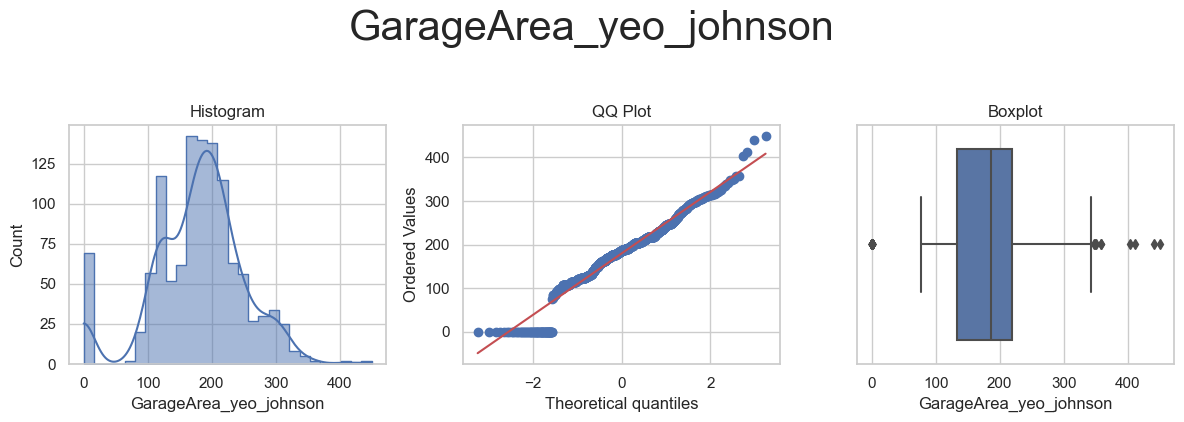



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



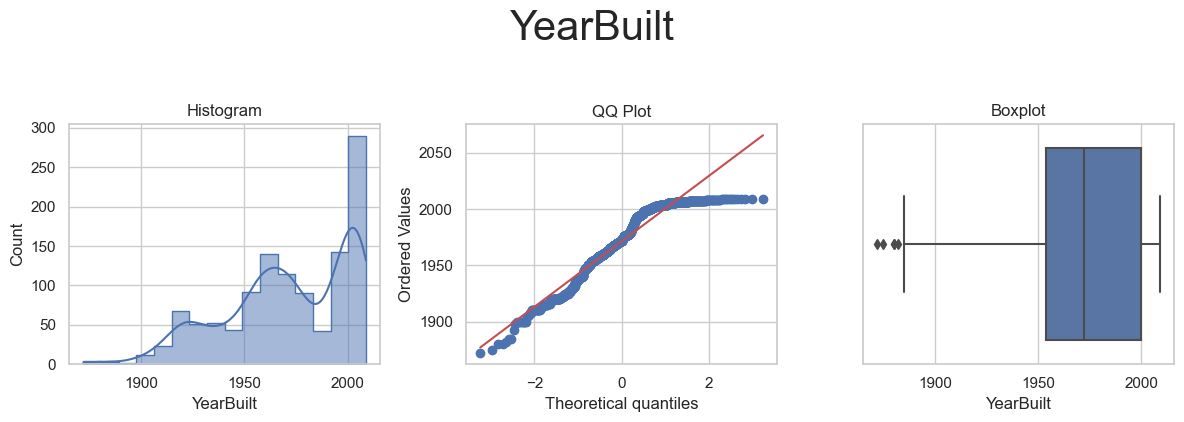

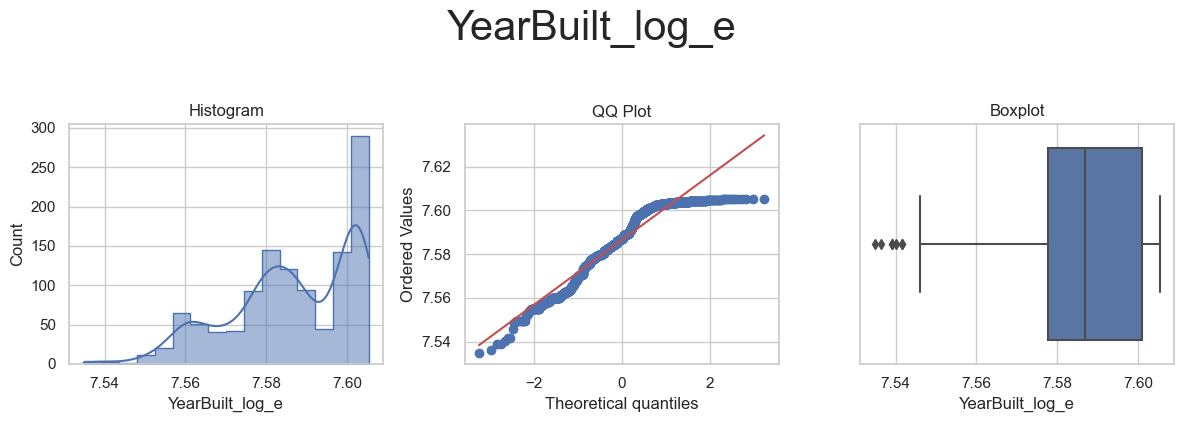

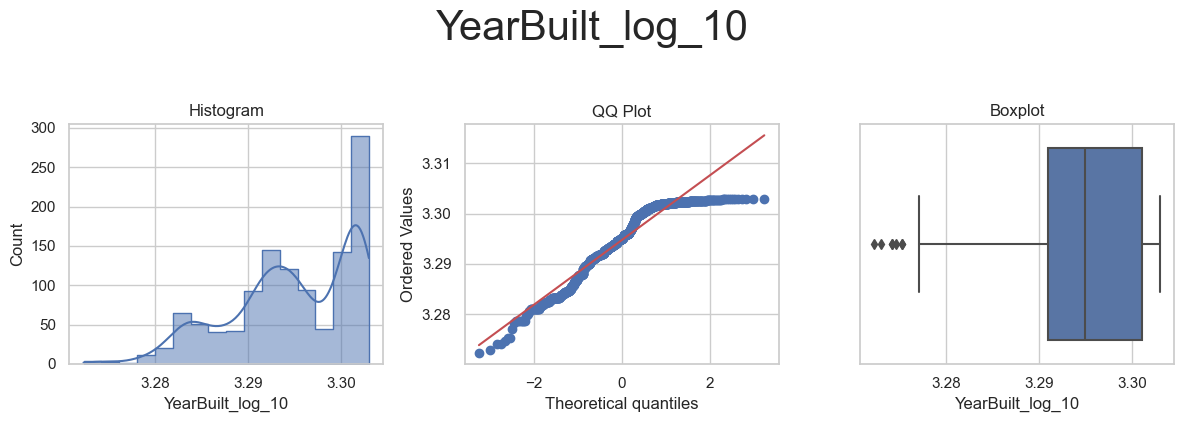

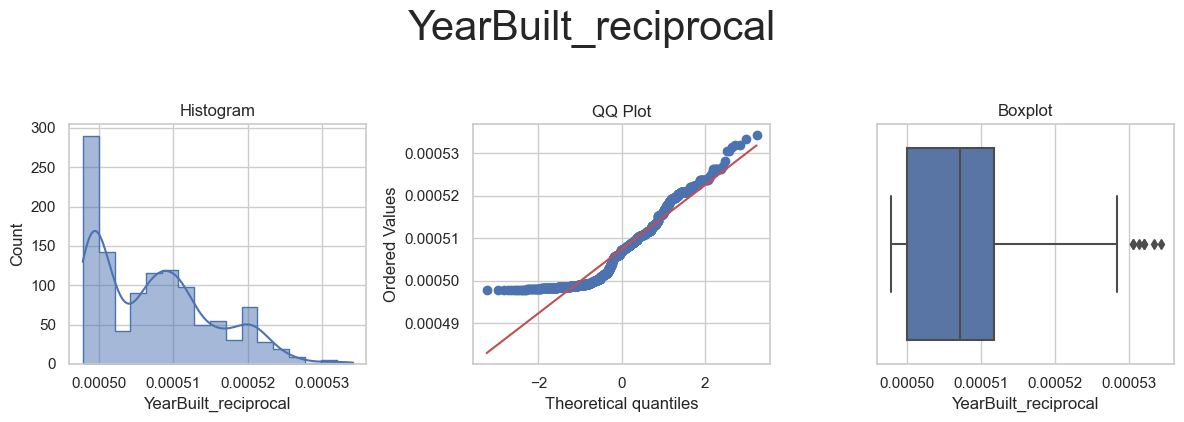

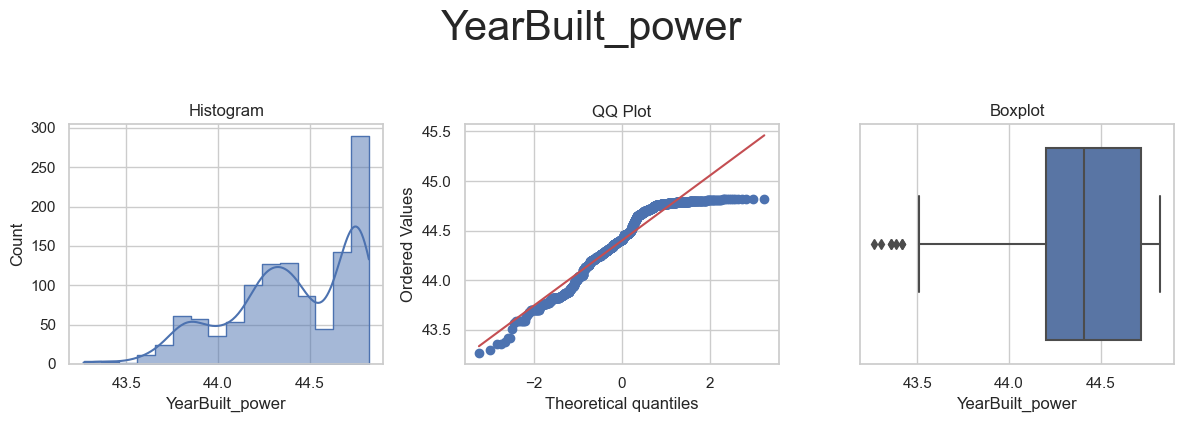

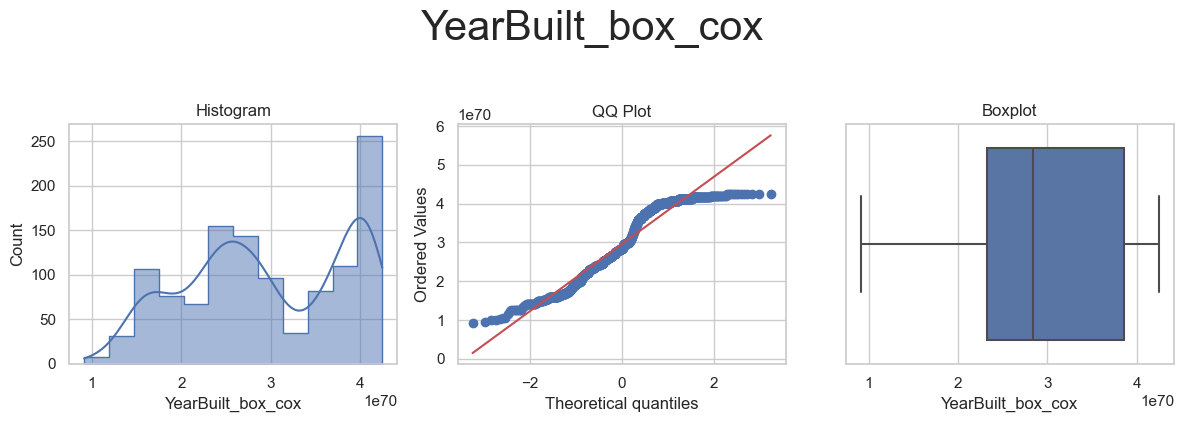

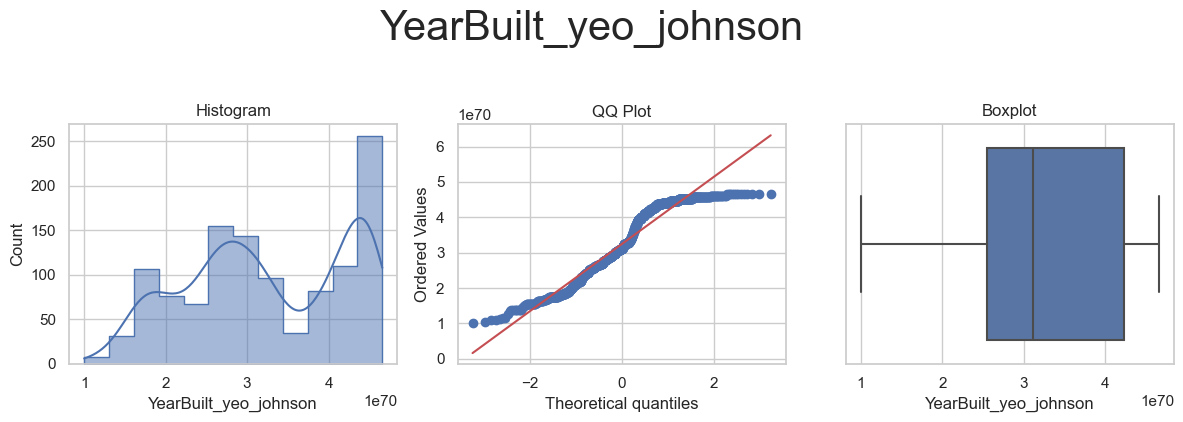



* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



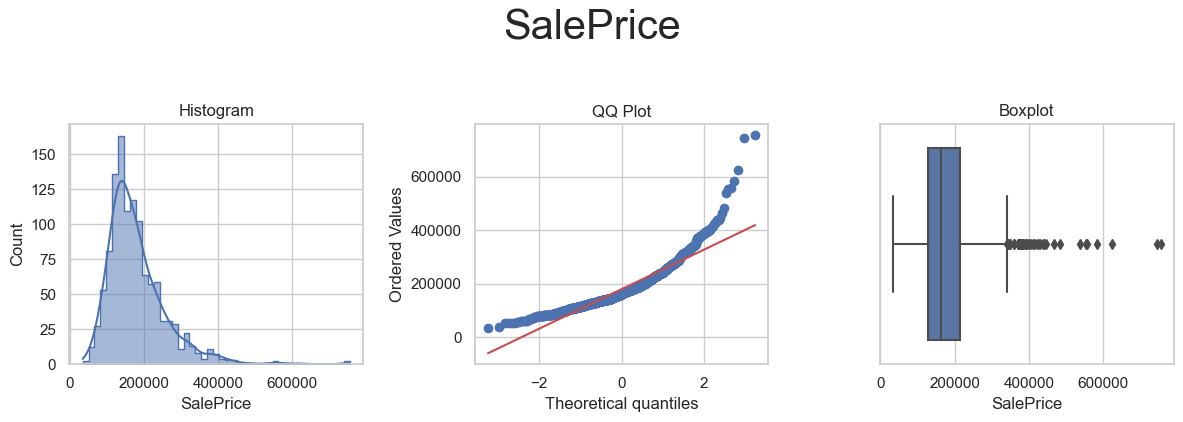

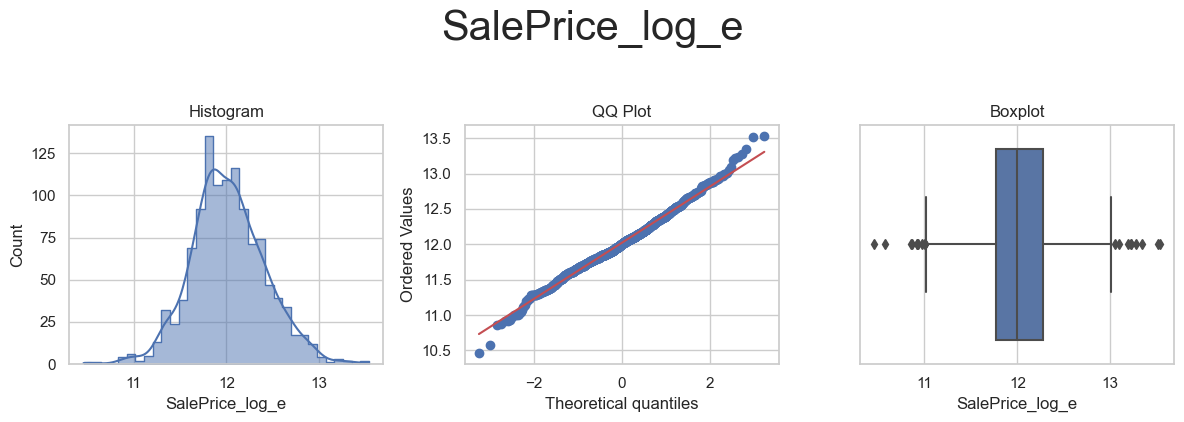

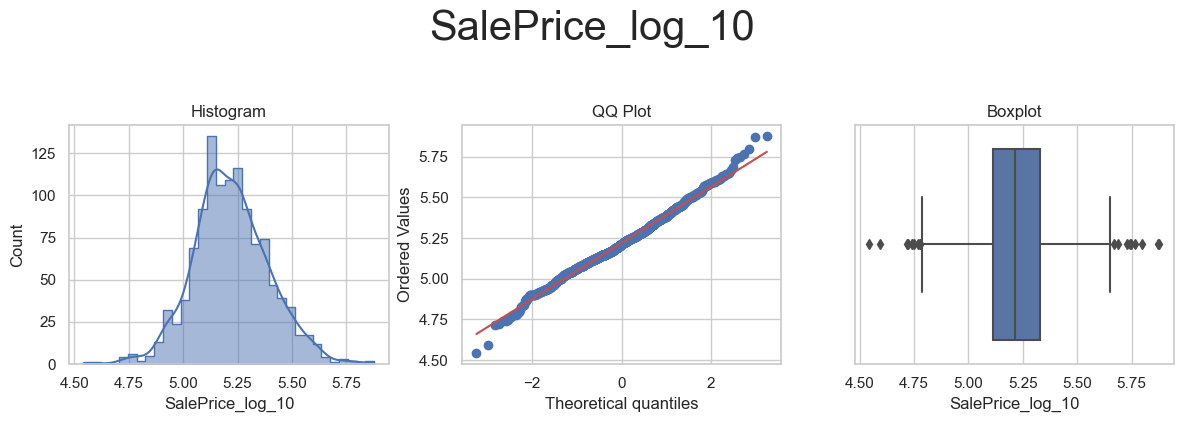

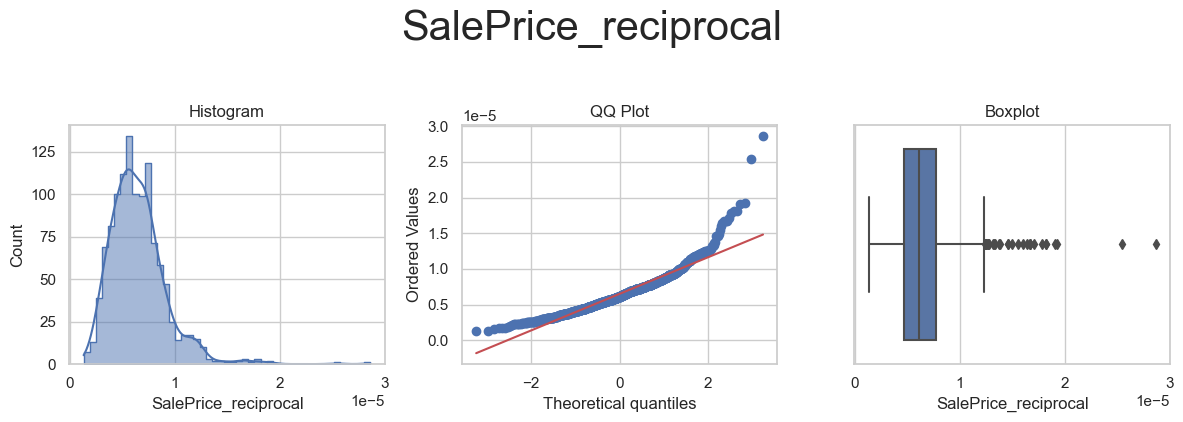

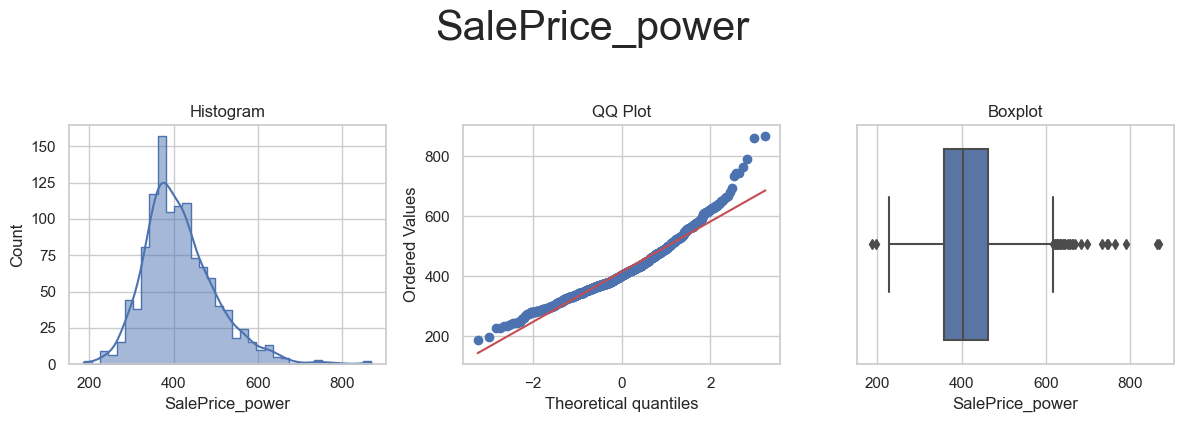

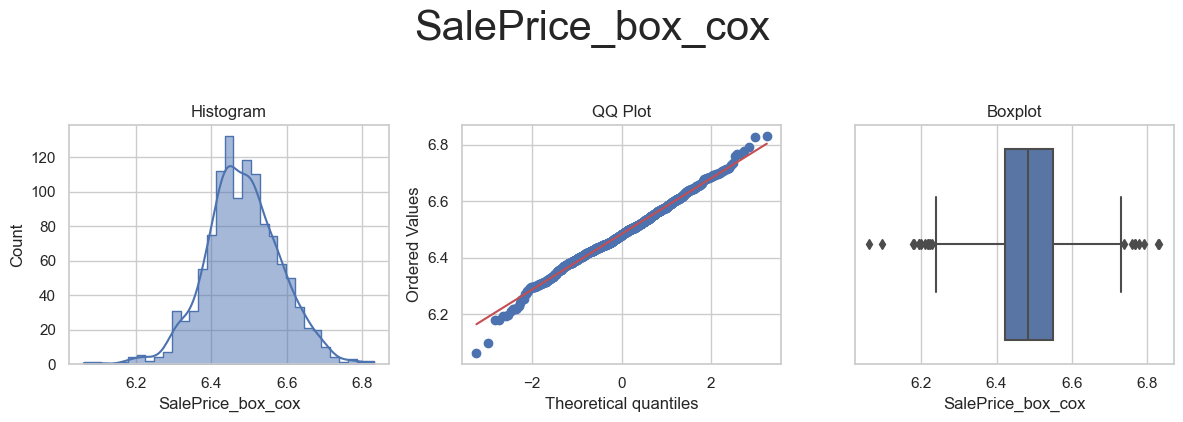

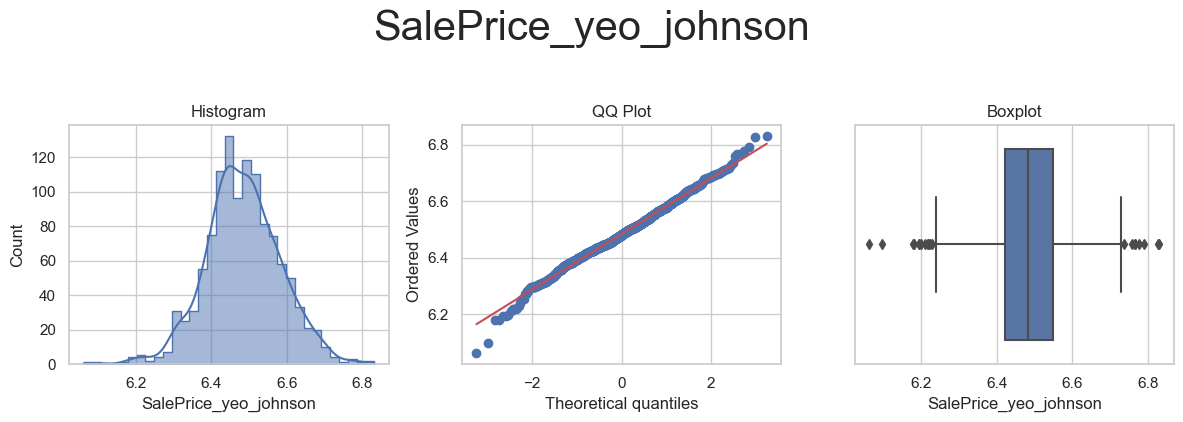

In [11]:
df_train_numerical = FeatureEngineeringAnalysis(df=df_train[numerical_features], analysis_type='numerical')

### Based on plots above we can select best transformations for each feature:

1. OverallQual: Log-e, Power, Original Values
2. GrLivArea: Log-e, Box Cox, Yeo Johnson, Original Values
3. 1stFlrSF: Log-e, Box_Cox, Yeo Johnson, Power, Original Values
4. TotalBsmtSF: Power, Yeo Johnson
5. GarageArea: Power, Original Values
6. YearBuilt: Log-e, Power, Box Cox
7. SalePrice: Log-e, Log-10, Box_Cox, Yeo Johnson, Original Values



### Selection of Transformations and further actions

To make an easier decision, we will use ydata profiling see all information we need
for that we will make a list of Features we want to explore

But first lets make a list of selected Feature and Combination of transformation

After ticking selections, Click button **Submit Selections**

In [12]:
import ipywidgets as widgets
from IPython.display import display


class InteractiveGrid:
    def __init__(self, rows, columns, data_list, callback=None):
        self.rows = rows
        self.columns = columns
        self.data_list = data_list  # This is your list of valid row_column combinations
        self.checkboxes = {}
        self.selected_items = []
        self.callback = callback
        self._setup_ui()

    def _setup_ui(self):
        grid_layout = widgets.Layout(width='80%', grid_template_columns='repeat(auto-fill, minmax(150px, 1fr))',
                                     grid_gap='10px')
        self.grid = widgets.GridspecLayout(len(self.rows) + 1, len(self.columns) + 1, layout=grid_layout)

        # Setting column headers
        for col_index, col in enumerate(self.columns, start=1):
            self.grid[0, col_index] = widgets.Label(value=col)

        # Setting row headers
        for row_index, row in enumerate(self.rows, start=1):
            self.grid[row_index, 0] = widgets.Label(value=row)

        # Creating checkboxes
        for row_index, row in enumerate(self.rows, start=1):
            for col_index, col in enumerate(self.columns, start=1):
                row_col_combination = f"{row}_{col}" if col != "Original" else f"{row}"
                if row_col_combination in self.data_list:  # Check if the combination is in the list
                    checkbox = widgets.Checkbox(value=False, description='', layout=widgets.Layout(width='auto'))
                    self.checkboxes[(row, col)] = checkbox
                    self.grid[row_index, col_index] = checkbox
                else:
                    self.grid[row_index, col_index] = widgets.Label('')  # Place a blank label if not in the list

        self.button = widgets.Button(description="Submit Selections")
        self.output = widgets.Output()
        self.button.on_click(self.on_button_clicked)
        display(self.grid, self.button, self.output)

    def on_button_clicked(self, b):
        # Adjusting the collection of selected items to handle 'Original' specially
        self.selected_items = [
            row if col == "Original" else f"{row}_{col}"
            for (row, col), checkbox in self.checkboxes.items() if checkbox.value
        ]
        with self.output:
            self.output.clear_output()
            if self.callback:
                self.callback(self.selected_items)


# Define your callback function that processes the selected items
def my_callback(selected_items):
    print("Selected transformations:", selected_items)


# Usage
columns = define_list_column_transformers('numerical')
columns.insert(0, 'Original')
rows = numerical_features
data_list = df_train_numerical.columns

grid = InteractiveGrid(rows, columns, data_list, callback=my_callback)
### Based on plots above we can select best transformations for each feature:

# 1. OverallQual: Log-e, Power, Original Values
# 2. GrLivArea: Log-e, Box Cox, Yeo Johnson, Original Values
# 3. 1stFlrSF: Log-e, Box_Cox, Yeo Johnson, Power, Original Values
# 4. TotalBsmtSF: Power, Yeo Johnson
# 5. GarageArea: Power, Original Values
# 6. YearBuilt: Log-e, Power, Box Cox
# 7. SalePrice: Log-e, Log-10, Box_Cox, Yeo Johnson, Original Values



GridspecLayout(children=(Label(value='Original', layout=Layout(grid_area='widget001')), Label(value='log_e', l…

Button(description='Submit Selections', style=ButtonStyle())

Output()

In [13]:
grid.selected_items

['OverallQual',
 'OverallQual_log_e',
 'OverallQual_power',
 'GrLivArea',
 'GrLivArea_log_e',
 'GrLivArea_box_cox',
 'GrLivArea_yeo_johnson',
 '1stFlrSF',
 '1stFlrSF_log_e',
 '1stFlrSF_power',
 '1stFlrSF_box_cox',
 '1stFlrSF_yeo_johnson',
 'TotalBsmtSF_power',
 'TotalBsmtSF_yeo_johnson',
 'GarageArea',
 'GarageArea_power',
 'YearBuilt_log_e',
 'YearBuilt_power',
 'YearBuilt_box_cox',
 'SalePrice',
 'SalePrice_log_e',
 'SalePrice_log_10',
 'SalePrice_box_cox',
 'SalePrice_yeo_johnson']

Now we have a list for ydata-profiling:

```['OverallQual', 'OverallQual_log_e', 'OverallQual_power', 'GrLivArea', 'GrLivArea_log_e', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson', 1stFlrSF', '1stFlrSF_log_e', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson', 'TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson', 'GarageArea', 'GarageArea_power', 'YearBuilt_box_cox', 'YearBuilt_log_e', 'YearBuilt_power', 'SalePrice', 'SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_box_cox', 'SalePrice_yeo_johnson']```
 

We will make a list of Features we will be correlating, so it will be 'SalePrice' and its transformations

We will save report as a file: outputs/reports/hypothesis_1_transformations_ydata_report.html

Saving as an external file is easier to see all data in browser

In [14]:
from ydata_profiling import ProfileReport

hypothesis_1_transformations_profile = ProfileReport(df_train_numerical[grid.selected_items], correlations={
    "pearson": {"calculate": True},
    "spearman": {"calculate": True},
    "kendall": {"calculate": True},
    "phi_k": {"calculate": True},
    "cramers": {"calculate": True}
})
hypothesis_1_transformations_profile.to_file('outputs/reports/hypothesis_1_transformations_ydata_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Final selection of transformation for features:

First lets check, maybe our target needs transformations:

**SalePrice** - BoxCox. Skewness is just -0.0096943996, same time it managed to reduce kurtosis from (original) 7.1753388 to 0.66402323. Yes it is a bit low. It is hard to choose between 2 extremes: 7.1 and 0.6, but second one at least has better skewness. As an extra option we can choose Yeo Johnson, results are very similar

Features:
1. OverallQual - Original Values. Somehow in Profile Report, OverallQual after transformations, skew values are different from plots we have observed. At this point i will trust more Profile Report than my coding for transformations.
2. GrLivArea - Box Cox. Kurtosis. Skewness = 0.0007368103, kurtosis = 0.12902342, overall distribution looks good and no extreme values
3. 1sfFlrSF - Yeo Johnson. Skewness is just 0.00060557042, while kurtosis is not inspiring = -0.11443746, extreme values not noticed
4. TotalBsmtSF - Yeo Johnson. Skewness -0.028003628, kurtosis 1.7998654, we have a bit of wide range of values from 0 and 49.42 up to 752.46. might need normalization 
5. GarageArea - Original Values, skewness is just 0.11419629 and kurtosis 0.8197573, also noticed extreme values from 0 till 1390
6. YearBuilt - Box Cox, skewness -0.13552187 and kurtosis is still negative -1.2199092. We have very high values, lowest is with e69, highest with e70, we will simply divide it by 1e69

## Conclusion

* Ordinal Encoder: ['BsmtFinType1', 'KitchenQual', 'BsmtExposure', 'GarageFinish']
* Numerical transformations:
    * Box Cox: ['GrLivArea', 'YearBuilt', 'SalePrice']
    * Yeo Johnson: ['1stFlrSF', TotalBsmtSF']
    *  'YearBuilt' divide by 1e69
* Original Values: ['OverallQual', 'GarageArea']
